# TRADE

In [1]:
import numpy as np
import pandas as pd
import sqlite3

import plotnine as p9
from mizani.breaks import date_breaks
from mizani.formatters import date_format, dollar_format

from ipynb.fs.defs.market_4_rank import (
    get_carg_histories,
    get_quantile_histories,
    get_tail,
    get_rank_histories)

### GET PRICE, CARG, AND RANK HISTORIES

In [2]:
con = sqlite3.connect('market.db')

price_histories = (
    pd.read_sql('SELECT * FROM sp5_close_histories', con, parse_dates=['Date'])
    .pivot(index='Date', columns='Symbol', values='Close'))

# display(close_histories)

In [3]:
carg_days = 63
q_days = 252
q = 0.75
tail_days = 2*252

carg_histories = get_carg_histories(price_histories, carg_days)
quantile_histories = get_quantile_histories(carg_histories, q_days, q)
quantile_histories = get_tail(quantile_histories, tail_days)
rank_histories = get_rank_histories(quantile_histories)

# display(carg_histories)
# display(quantile_histories)
# display(rank_histories)

In [4]:
rank_histories

Symbol,A,AAL,AAP,AAPL,ABBV,ABC,ABMD,ABT,ACN,ADBE,...,WYNN,XEL,XOM,XRAY,XYL,YUM,ZBH,ZBRA,ZION,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2020-05-15,234,470,469,15,72,314,482,329,197,113,...,360,271,484,194,432,253,162,65,388,97
2020-05-18,234,470,469,15,72,313,481,329,204,112,...,358,279,484,200,432,252,161,65,387,97
2020-05-19,234,471,469,15,72,312,480,328,208,113,...,357,284,484,202,431,252,160,65,387,96
2020-05-20,234,471,469,15,72,311,478,328,218,112,...,357,283,485,203,431,252,160,65,386,97
2020-05-21,232,470,471,15,72,313,478,328,218,112,...,356,283,485,210,431,251,160,65,386,97
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-09,115,469,190,127,32,143,362,386,149,59,...,490,323,53,485,155,275,463,302,187,73
2022-05-10,115,469,190,127,32,139,360,384,143,59,...,490,324,53,485,159,272,463,305,188,72
2022-05-11,114,469,191,126,32,137,360,384,141,59,...,490,325,52,485,158,268,463,304,188,72


### TRADE

In [5]:
def trade(price_histories, rank_histories, rank_keep=20, num_hold=10, cash= 5_000):

    positions = pd.Series(dtype='float64')
    balance_history = pd.Series(dtype='float64')
    transaction_history = pd.DataFrame()

    for date, _ in rank_histories.iterrows():
        prices = price_histories.loc[date]  
        ranks = rank_histories.loc[date]

        logic1 = ranks > rank_keep
        num_sell = sum(logic1)
        if num_sell > 0:
            
            # GET SYMBOLS TO SELL
            logic2 = ranks.index.isin(positions.index)
            rank_sells = ranks[logic1 & logic2]
            symbol_sells = rank_sells.sort_values(ascending=False).index.to_list()

            # SELL
            for symbol in symbol_sells:
                transaction = {
                    'Date': date,
                    'Action': 'Sell',
                    'Qty': positions[symbol],
                    'Symbol': symbol,
                    'Price': prices[symbol],
                    'Change': +positions[symbol]*prices[symbol],
                    'Rank': ranks[symbol]}

                positions = positions.drop(symbol)
                cash += transaction['Change']
                transaction_history = pd.concat([transaction_history,
                    pd.DataFrame(transaction, index=[0])], ignore_index=True)

        num_buy = num_hold - len(positions)
        if num_buy > 0:
            cash_per = cash/num_buy

            # GET SYMBOLS TO BUY
            logic1 = prices <= cash_per
            logic2 = ranks.index.isin(prices[logic1].index)
            logic3 = ranks.index.isin(positions.index)
            rank_buys = ranks[logic2 & ~logic3].nsmallest(num_buy)
            symbol_buys = rank_buys.index.to_list()

            # BUY
            for symbol in symbol_buys:
                transaction = {
                    'Date': date,
                    'Action': 'Buy',
                    'Qty': int(cash_per/prices[symbol]),
                    'Symbol': symbol,
                    'Price': prices[symbol],
                    'Change': -int(cash_per/prices[symbol])*prices[symbol],
                    'Rank': ranks[symbol]}

                positions[symbol] = transaction['Qty']
                cash += transaction['Change']
                transaction_history = pd.concat([transaction_history,
                    pd.DataFrame(transaction, index=[0])], ignore_index=True)

        balance = cash + (positions*prices).sum()
        balance_history[date] = balance
        

    # AT THHE END, ADD SYMBOLS THAT ARE OWNED
    logic = ranks.index.isin(positions.index)
    ranks_own = ranks[logic].sort_values()
    symbols_own = ranks_own.index.to_list()
    
    # ADD OWNED
    for symbol in symbols_own:
        transaction = {
            'Date': date,
            'Action': 'Owned',
            'Qty': positions[symbol],
            'Symbol': symbol,
            'Price': prices[symbol],
            'Change': +positions[symbol]*prices[symbol],
            'Rank': ranks[symbol]}

        transaction_history = pd.concat([transaction_history,
            pd.DataFrame(transaction, index=[0])], ignore_index=True)

    return balance_history.rename('Balance').rename_axis('Date'), transaction_history

In [6]:
balance_history, transaction_history = trade(price_histories, rank_histories)

display(balance_history)
display(transaction_history)

Date
2020-05-15     5000.000000
2020-05-18     5330.059010
2020-05-19     5312.351328
2020-05-20     5407.979046
2020-05-21     5326.144863
                  ...     
2022-05-09    16825.132017
2022-05-10    17084.546141
2022-05-11    17132.525997
2022-05-12    17162.195885
2022-05-13    18261.016008
Name: Balance, Length: 504, dtype: float64

,Date,Action,Qty,Symbol,Price,Change,Rank
0,2020-05-15,Buy,8,ENPH,58.380001,-467.040009,1
1,2020-05-15,Buy,3,TSLA,159.834000,-479.501999,2
2,2020-05-15,Buy,4,SEDG,120.440002,-481.760010,3
3,2020-05-15,Buy,1,DXCM,417.730011,-417.730011,4
4,2020-05-15,Buy,7,MRNA,66.690002,-466.830017,5
5,2020-05-15,Buy,9,AMD,54.200001,-487.800007,6
6,2020-05-15,Buy,4,GNRC,104.699997,-418.799988,8
7,2020-05-15,Buy,5,QRVO,94.709999,-473.549995,9
8,2020-05-15,Buy,21,CZR,23.209999,-487.409981,10
9,2020-05-15,Buy,1,MKTX,482.018127,-482.018127,11


In [7]:
display(transaction_history
    .sort_values(['Symbol', 'Date'])
    .set_index(['Symbol', 'Date']))

Action  Qty       Price       Change  Rank
Symbol Date                                                 
ALGN   2020-07-15    Buy    2  314.299988  -628.599976     6
       2021-08-16   Sell    2  690.750000  1381.500000    23
AMD    2020-05-15    Buy    9   54.200001  -487.800007     6
       2020-07-28   Sell    9   67.610001   608.490005    21
       2022-03-16    Buy   11  115.370003 -1269.070030     9
       2022-05-13  Owned   11   95.120003  1046.320030     9
APA    2022-01-10    Buy   71   29.223789 -2074.889034     6
       2022-05-13  Owned   71   41.150002  2921.650108     3
BBWI   2020-11-25    Buy   26   31.163078  -810.240036     5
       2022-03-08   Sell   26   45.590000  1185.340004    22
CZR    2020-05-15    Buy   21   23.209999  -487.409981    10
       2021-03-23   Sell   21   84.589996  1776.389923    21
DVN    2021-12-29    Buy   34   43.470264 -1477.988991     3
       2022-05-13  Owned   34   68.699997  2335.799896     2
DXCM   2020-05-15    Buy    1  417.730011  -417.730011     4
       2021-01-11   Sell    1  370.640015   370.640015    21
ENPH   2020-05-15    Buy    8   58.380001  -467.040009     1
       2021-12-29   Sell    8  185.470001  1483.760010    22
ETSY   2020-12-24    Buy    3  190.309998  -570.929993     7
       2021-08-25   Sell    3  202.279999   606.839996    26
F      2022-01-13    Buy   23   24.892021  -572.516487     7
       2022-04-11   Sell   23   15.280000   351.439994    21
FANG   2021-08-25    Buy    8   72.611298  -580.890381     8
       2022-05-13  Owned    8  133.429993  1067.439941    15
FCX    2021-01-11    Buy   13   29.931953  -389.115395     7
       2022-01-13   Sell   13   44.191471   574.489124    23
FTNT   2022-02-17    Buy    8  310.540009 -2484.320068     7
       2022-05-13  Owned    8  281.549988  2252.399902    14
GNRC   2020-05-15    Buy    4  104.699997  -418.799988     8
       2020-07-15   Sell    4  133.949997   535.799988    21
IT     2022-04-11    Buy    1  288.790009  -288.790009     9
       2022-05-13  Owned    1  255.520004   255.520004    11
MKTX   2020-05-15    Buy    1  482.018127  -482.018127    11
       2020-07-23   Sell    1  502.886963   502.886963    21
MRNA   2020-05-15    Buy    7   66.690002  -466.830017     5
       2022-05-13  Owned    7  137.910004   965.370026     1
MRO    2021-03-23    Buy  179   10.024014 -1794.298591     5
       2022-05-13  Owned  179   27.000000  4833.000000     5
NUE    2022-03-08    Buy   11  125.541527 -1380.956795     8
       2022-05-13  Owned   11  123.790001  1361.690010    17
NVDA   2022-01-19    Buy    6  250.627304 -1503.763824     8
       2022-05-13  Owned    6  177.059998  1062.359985     4
OXY    2021-08-16    Buy   63   24.713015 -1556.919920     7
       2022-01-10   Sell   63   32.302906  2035.083080    21
PENN   2020-07-23    Buy   22   33.840000  -744.480003     8
       2021-10-15   Sell   22   77.699997  1709.399933    24
QRVO   2020-05-15    Buy    5   94.709999  -473.549995     9
       2020-11-25   Sell    5  148.240005   741.200027    21
SBNY   2021-08-10    Buy    4  252.968552 -1011.874207     5
       2022-03-16   Sell    4  319.784790  1279.139160    24
SEDG   2020-05-15    Buy    4  120.440002  -481.760010     3
       2021-08-10   Sell    4  296.399994  1185.599976    21
SWKS   2020-07-28    Buy    4  132.959778  -531.839111    10
       2020-12-24   Sell    4  150.353699   601.414795    22
TPR    2021-10-15    Buy   44   38.712467 -1703.348557     7
       2022-01-19   Sell   44   37.233517  1638.274734    21
TSLA   2020-05-15    Buy    3  159.834000  -479.501999     2
       2022-02-17   Sell    3  876.349976  2629.049927    21

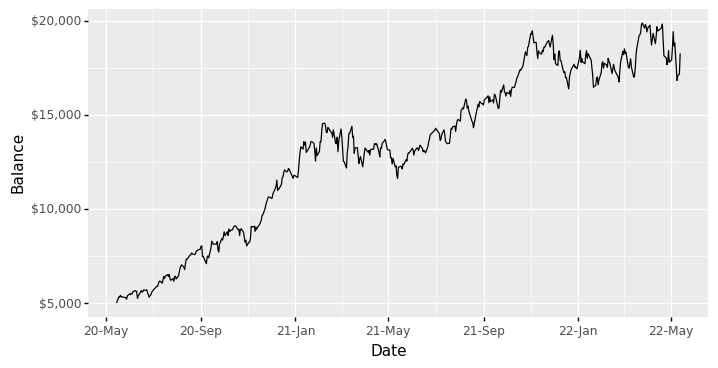

<ggplot: (8782869708611)>

In [8]:
df = balance_history.reset_index()

p = (p9.ggplot(data=df, mapping=p9.aes(x='Date', y='Balance'))
    + p9.theme(figure_size=(8, 4))
    + p9.scale_x_datetime(breaks=date_breaks('4 months'), labels=date_format('%y-%b'))
    + p9.geom_line()
    + p9.scale_y_continuous(labels=dollar_format(prefix='$', digits=0, big_mark=',')))

display(p)